In [1]:
# run CW ODMR.
# control the frequency changes "manually" with the code here instead of using external trigger

In [1]:
%matplotlib inline

In [1]:
import nidaqmx
import numpy as np
import qt3rfsynthcontrol
import ctypes
import nidaqmx._lib  # Due to NIDAQmx C-API bug needed to bypass property getter (according to qudi)
import nidaqmx.stream_readers
import time
import matplotlib.pyplot as plt
import qcsapphire


In [2]:
nisys = nidaqmx.system.System()
device = nidaqmx.system.Device('Dev1')

In [3]:
list(nisys.tasks)

[]

In [4]:
device.reset_device()

In [5]:
#list(nisys.devices)

In [6]:
#device = nidaqmx.system.Device('Dev1')
#list(device.ao_physical_chans)
# list(device.ai_physical_chans)
#list(device.di_lines)
#list(device.do_lines)
#list(device.co_physical_chans)
#list(device.ci_physical_chans)
# list(device.terminals)

In [7]:
#Configure the NI DAQ

def configure_tasks(post_fix_task_name = None, 
                    device_name = 'Dev1',
                    clock_counter = 'ctr1',
                    clock_di_line = 'port0',
                    edge_input_channel = 'PFI12',
                    edge_input_counter = 'ctr2',
                    clock_rate = 1000, 
                    N_data_samples_to_acquire = 500,
                    trigger_input = None,
                    new_edge_task = False,
                    new_clock_task = False):
   
    clock_task_name = f'sample_clock{post_fix_task_name}' 
    clock_task = nidaqmx.Task(clock_task_name)
       
    if new_clock_task:
        clock_task.di_channels.add_di_chan(f'{device_name}/{clock_di_line}')
        clock_task.timing.cfg_samp_clk_timing(clock_rate,
                                    sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS)
     
        clock_channel = f'/{device_name}/di/SampleClock'

    else:
        #this adds the clock signal to the output channel
        #is this necessary? 
        clock_task.co_channels.add_co_pulse_chan_freq(
                '/{0}/{1}'.format(device_name, clock_counter),
                freq=clock_rate,
                idle_state=nidaqmx.constants.Level.LOW)

        # clock_task.timing.cfg_implicit_timing(
        #     sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
        #     samps_per_chan=n_steps+2) #qudi configures with n_steps + 1, should recheck why. suspicious extra "1" floating around (n_steps = 101)

        clock_task.timing.cfg_implicit_timing(
            sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS,
            samps_per_chan=clock_rate) #qudi configures with n_steps + 1, should recheck why. suspicious extra "1" floating around (n_steps = 101)

        clock_channel = '/{0}InternalOutput'.format(clock_task.channel_names[0])

    edge_detector_task_name = f'edge_input{post_fix_task_name}'

    edge_detector_task = nidaqmx.Task(edge_detector_task_name)

    #todo -- try to replace all of this with edge_detector_task.add_ci_count_edges_chan
    
    

    ctr_name = f'/{device_name}/{edge_input_counter}'
    chnl_name = f'/{device_name}/{edge_input_channel}'
    
    if new_edge_task: #following nspyre recipe
        edge_detector_task.ci_channels.add_ci_count_edges_chan(
                                    ctr_name,
                                    edge=nidaqmx.constants.Edge.RISING,
                                    initial_count=0,
                                    count_direction=nidaqmx.constants.CountDirection.COUNT_UP)
        edge_detector_task.ci_channels.all.ci_count_edges_term = chnl_name
        edge_detector_task.timing.cfg_samp_clk_timing(clock_rate, 
                                                      source=clock_channel,
                                                      active_edge=nidaqmx.constants.Edge.RISING, 
                                                      sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS)
        # edge_detector_task.timing.cfg_samp_clk_timing(clock_rate, 
        #                                               source=clock_channel,
        #                                               active_edge=nidaqmx.constants.Edge.RISING, 
        #                                               sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
        #                                               samps_per_chan=N_data_samples_to_acquire )
        
    else:
        # why does qudi count the period of signal? In units of "ticks" -- is that the same as edge counting? 
        
        edge_detector_task.ci_channels.add_ci_period_chan(
                            ctr_name,
                            min_val=0,
                            max_val=100000000,
                            units=nidaqmx.constants.TimeUnits.TICKS,
                            edge=nidaqmx.constants.Edge.RISING)
        # I get no data when I swap out the line above for this line
        # edge_detector_task.ci_channels.add_ci_count_edges_chan(
        #                             ctr_name,
        #                             edge=nidaqmx.constants.Edge.RISING,
        #                             initial_count=0,
        #                             count_direction=nidaqmx.constants.CountDirection.COUNT_UP)
        
        # from qudi -- apparently this overcomes some kind of bug in the C-library, according to comments in qudi code
        print('here')
        try:
            # this sets the counter to read from the appropriate terminal
            nidaqmx._lib.lib_importer.windll.DAQmxSetCIPeriodTerm(
                edge_detector_task._handle,
                ctypes.c_char_p(ctr_name.encode('ascii')),
                ctypes.c_char_p(clock_channel.encode('ascii')))
            
            #this tells the counter which clock to use
            nidaqmx._lib.lib_importer.windll.DAQmxSetCICtrTimebaseSrc(
                edge_detector_task._handle,
                ctypes.c_char_p(ctr_name.encode('ascii')),
                ctypes.c_char_p(chnl_name.encode('ascii')))
        except:
            nidaqmx._lib.lib_importer.cdll.DAQmxSetCIPeriodTerm(
                edge_detector_task._handle,
                ctypes.c_char_p(ctr_name.encode('ascii')),
                ctypes.c_char_p(clock_channel.encode('ascii')))
            nidaqmx._lib.lib_importer.cdll.DAQmxSetCICtrTimebaseSrc(
                edge_detector_task._handle,
                ctypes.c_char_p(ctr_name.encode('ascii')),
                ctypes.c_char_p(chnl_name.encode('ascii')))

        edge_detector_task.timing.cfg_implicit_timing(sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
                                                      samps_per_chan=N_data_samples_to_acquire)
    
    if trigger_input:
        edge_detector_task.triggers.arm_start_trigger.trig_type =  nidaqmx.constants.TriggerType.DIGITAL_EDGE
        edge_detector_task.triggers.arm_start_trigger.dig_edge_edge =  nidaqmx.constants.Edge.RISING
        edge_detector_task.triggers.arm_start_trigger.dig_edge_src = f'/{device_name}/{trigger_input}'
    

    edge_detector_reader = nidaqmx.stream_readers.CounterReader(edge_detector_task.in_stream)
    
    return clock_task, edge_detector_task, edge_detector_reader



In [8]:
def run_once(detector_task, detector_reader, clock_rate,  N_samples,  read_write_timeout=10, pulser = None):
    
    detector_task.wait_until_done()
    detector_task.start()
    data_buffer = np.zeros(N_samples)
    
    if pulser:
        pulser.software_trigger()

    read_samples = detector_reader.read_many_sample_double(
                            data_buffer,
                            number_of_samples_per_channel=N_samples,
                            timeout=read_write_timeout)
    detector_task.stop()
    try:
        assert read_samples == N_samples
    except Exception as e:
        print(e)
        print(f'{read_samples} != {N_samples}')
        raise e
        
    return data_buffer

In [9]:
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [10]:
rfsynth.hw_info()

[('model_type', 'WFT SynthHD 1694'),
 ('serial_number', 1694),
 ('fw_version', 'Firmware Version 3.23'),
 ('hw_version', 'Hardware Version 2.06'),
 ('sub_version', 'HD')]

In [11]:
qcsapphire.discover_devices()

[['COM3',
  'Intel(R) Active Management Technology - SOL (COM3)',
  'PCI\\VEN_8086&DEV_43E3&SUBSYS_0A541028&REV_11\\3&11583659&1&B3'],
 ['COM5',
  'USB Serial Device (COM5)',
  'USB VID:PID=0483:A3E5 SER=206A36705430 LOCATION=1-2:x.0'],
 ['COM7',
  'USB Serial Device (COM7)',
  'USB VID:PID=239A:8014 SER=3B0D07C25831555020312E341A3214FF LOCATION=1-6:x.0']]

In [12]:
p = qcsapphire.Pulser('COM6')

SerialException: could not open port 'COM6': FileNotFoundError(2, 'The system cannot find the file specified.', None, 2)

In [13]:
p.set_all_state_off()

NameError: name 'p' is not defined

In [40]:
## set up for software trigger pulses on channel B
p.pulse0.mode('single')
p.pulse0.period(0.0001) # 100 mus period
p.pulse0.external.mode('trigger')
p.pulse2.cmode('single')
p.pulse2.polarity('normal')
p.pulse2.width(0.000001) # 1 mus wide pulse

'ok'

In [17]:

def run_with_options(freq_low, freq_high, freq_step,
                     N_samples_per_step, clock_rate, 
                     trigger_input, pulser, use_new_edge_task, new_clock_task):


    data = None


    try:
        daq_time = N_samples_per_step / clock_rate
        print(f'acquiring {daq_time} seconds of data per sample')

        clock_task, edge_detector_task, edge_detector_reader = configure_tasks(post_fix_task_name = 'v12', 
                                                                                    clock_rate = clock_rate, 
                                                                                    N_data_samples_to_acquire = N_samples_per_step,
                                                                                    edge_input_channel = 'PFI12',
                                                                                    clock_counter = 'ctr1',
                                                                                    trigger_input = trigger_input,
                                                                                    new_edge_task = use_new_edge_task,
                                                                                    new_clock_task = new_clock_task)

        if clock_task:
            clock_task.start()

        data = {}
        rfsynth.rf_on(0)
        current_freq = freq_low
        step = 0

        if pulser:
            pulser.pulse0.state(1)
            pulser.pulse2.state(1)

        while current_freq < freq_high:
            rfsynth.set_channel_fixed_output(0, -5.0, current_freq)
            data_at_one_freq = run_once(edge_detector_task, edge_detector_reader, clock_rate, N_samples_per_step, read_write_timeout = 10, pulser = pulser)
            data[current_freq] = data_at_one_freq.mean()*clock_rate
            if step % 10 == 0:
                print(f'{current_freq/1e9} GHz: {data_at_one_freq.mean()} mean counts')
                print(f'{current_freq/1e9} GHz: {data_at_one_freq.mean()*clock_rate} mean counts/second')
            current_freq += freq_step
            step += 1
    except Exception as e:
        raise(e)

    finally:

        try:
            rfsynth.rf_off(0)
            if pulser:
                pulser.pulse0.state(0)
                pulser.pulse2.state(0)
        except Exception as e:
            print(e)

        try:
            if clock_task:
                clock_task.stop()
        except Exception as e:
            print(e)

        try:
            if clock_task:
                clock_task.close()
        except Exception as e:
            print(e)

        try:
            if edge_detector_task:
                edge_detector_task.close()
        except Exception as e:
            print(e)
            
        return data

In [108]:
# freq_low = 2820e6
# freq_high = 3130e6
# freq_step = 10e6

# # pulsed, triggered
# # N = 2
# # clock_rate = int(400e3) #400 kHz -- N = 2 samples, this is a 5 mu second window of data acquisition, equal to pulsed ODMR
# # N = 8
# # clock_rate = int(1600e3)
# # trigger_input = 'PFI0'
# # pulser = p

# # cw odmr


# N = 50
# clock_rate = int(200)
# # trigger_input = 'PFI0'
# # pulser = p
# # trigger_input = None
# # pulser = None


#qudi style, ODMR
freq_low = 2820e6
freq_high = 3130e6
freq_step = 10e6
N = 50
clock_rate = 200 #Hz
trigger_input = None
pulser = None
use_new_edge_task = False
new_clock_task = False

data_qudi_style = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, trigger_input, pulser, use_new_edge_task, new_clock_task)

acquiring 0.25 seconds of data per sample
2.82 GHz: 175311.0 counts
2.82 GHz: 701244.0 counts/second
2.92 GHz: 174296.0 counts
2.92 GHz: 697184.0 counts/second
3.02 GHz: 175414.0 counts
3.02 GHz: 701656.0 counts/second
3.12 GHz: 174812.0 counts
3.12 GHz: 699248.0 counts/second


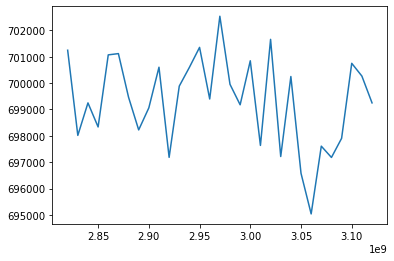

In [144]:
plt.plot(data_qudi_style.keys(), data_qudi_style.values())

In [142]:
#base settings
freq_low = 2820e6
freq_high = 3130e6
freq_step = 2e6
N = 50
clock_rate = 200 #Hz
trigger_input = None
pulser = None
use_new_edge_task = False
new_clock_task = False

#changed settings
trigger_input = 'PFI0'
pulser = p

data_qudi_style_with_ext_trigger = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, trigger_input, pulser, use_new_edge_task, new_clock_task)

acquiring 0.25 seconds of data per sample
here
2.82 GHz: 14817.0 counts
2.82 GHz: 59268.0 counts/second
2.84 GHz: 15149.0 counts
2.84 GHz: 60596.0 counts/second
2.86 GHz: 14546.0 counts
2.86 GHz: 58184.0 counts/second
2.88 GHz: 15089.0 counts
2.88 GHz: 60356.0 counts/second
2.9 GHz: 15881.0 counts
2.9 GHz: 63524.0 counts/second
2.92 GHz: 16544.0 counts
2.92 GHz: 66176.0 counts/second
2.94 GHz: 17260.0 counts
2.94 GHz: 69040.0 counts/second
2.96 GHz: 17561.0 counts
2.96 GHz: 70244.0 counts/second
2.98 GHz: 17385.0 counts
2.98 GHz: 69540.0 counts/second
3.0 GHz: 17283.0 counts
3.0 GHz: 69132.0 counts/second
3.02 GHz: 17108.0 counts
3.02 GHz: 68432.0 counts/second
3.04 GHz: 17423.0 counts
3.04 GHz: 69692.0 counts/second
3.06 GHz: 17312.0 counts
3.06 GHz: 69248.0 counts/second
3.08 GHz: 17353.0 counts
3.08 GHz: 69412.0 counts/second
3.1 GHz: 17228.0 counts
3.1 GHz: 68912.0 counts/second
3.12 GHz: 17479.0 counts
3.12 GHz: 69916.0 counts/second


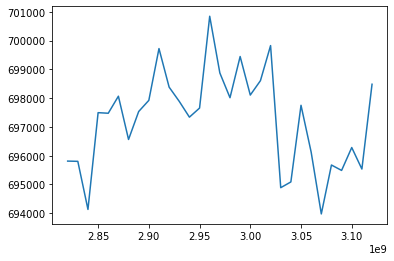

In [104]:
plt.plot(data_qudi_style_with_ext_trigger.keys(), data_qudi_style_with_ext_trigger.values())

In [111]:
#base settings
freq_low = 2820e6
freq_high = 3130e6
freq_step = 10e6
N = 50
clock_rate = 200 #Hz
trigger_input = None
pulser = None
use_new_edge_task = False
new_clock_task = False

#changed settings
use_new_edge_task = True

new_edge_counter_style = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, trigger_input, pulser, use_new_edge_task, new_clock_task)

acquiring 0.25 seconds of data per sample
2.82 GHz: 4334134.0 counts
2.82 GHz: 17336536.0 counts/second
2.92 GHz: 4377807.0 counts
2.92 GHz: 17511228.0 counts/second
3.02 GHz: 4414877.0 counts
3.02 GHz: 17659508.0 counts/second
3.12 GHz: 4391943.0 counts
3.12 GHz: 17567772.0 counts/second


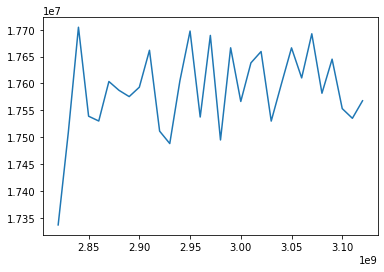

In [112]:
#almost a factor of 3 more data! ???
plt.plot(new_edge_counter_style.keys(), new_edge_counter_style.values())

In [114]:
#base settings
freq_low = 2820e6
freq_high = 3130e6
freq_step = 10e6
N = 50
clock_rate = 200 #Hz
trigger_input = None
pulser = None
use_new_edge_task = False
new_clock_task = False

#changed settings
use_new_edge_task = True
trigger_input = 'PFI0'
pulser = p

new_edge_counter_style_with_trigger = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, trigger_input, pulser, use_new_edge_task, new_clock_task)

acquiring 0.25 seconds of data per sample
2.82 GHz: 4368275.0 counts
2.82 GHz: 17473100.0 counts/second
2.92 GHz: 4403423.0 counts
2.92 GHz: 17613692.0 counts/second
3.02 GHz: 4382603.0 counts
3.02 GHz: 17530412.0 counts/second
3.12 GHz: 4402625.0 counts
3.12 GHz: 17610500.0 counts/second


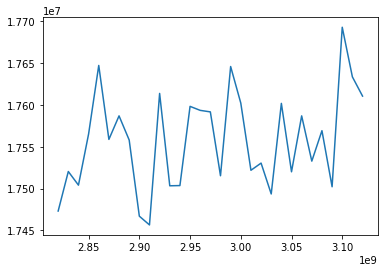

In [116]:
plt.plot(new_edge_counter_style_with_trigger.keys(), new_edge_counter_style_with_trigger.values())

acquiring 0.25 seconds of data per sample
2.82 GHz: 175416.0 counts
2.82 GHz: 701664.0 counts/second
2.92 GHz: 175156.0 counts
2.92 GHz: 700624.0 counts/second
3.02 GHz: 175600.0 counts
3.02 GHz: 702400.0 counts/second
3.12 GHz: 174769.0 counts
3.12 GHz: 699076.0 counts/second


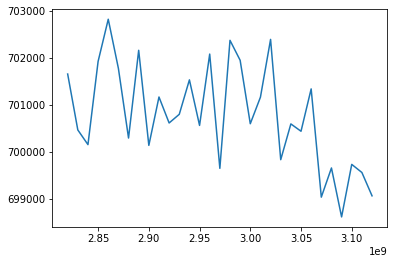

In [117]:
#base settings
freq_low = 2820e6
freq_high = 3130e6
freq_step = 10e6
N = 50
clock_rate = 200 #Hz
trigger_input = None
pulser = None
use_new_edge_task = False
new_clock_task = False

#changed settings
new_clock_task = True 

qudi_style_but_new_clock = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, trigger_input, pulser, use_new_edge_task, new_clock_task)
plt.plot(qudi_style_but_new_clock.keys(), qudi_style_but_new_clock.values())

acquiring 0.25 seconds of data per sample
2.82 GHz: 4378610.0 counts
2.82 GHz: 17514440.0 counts/second
2.92 GHz: 4376892.0 counts
2.92 GHz: 17507568.0 counts/second
3.02 GHz: 4372412.0 counts
3.02 GHz: 17489648.0 counts/second
3.12 GHz: 4398306.0 counts
3.12 GHz: 17593224.0 counts/second


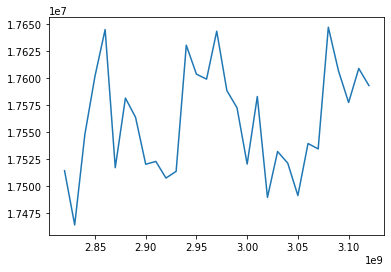

In [118]:
#base settings
freq_low = 2820e6
freq_high = 3130e6
freq_step = 10e6
N = 50
clock_rate = 200 #Hz
trigger_input = None
pulser = None
use_new_edge_task = False
new_clock_task = False

#changed settings
use_new_edge_task = True
new_clock_task = True

new_edge_and_new_clock_style = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, trigger_input, pulser, use_new_edge_task, new_clock_task)
plt.plot(new_edge_and_new_clock_style.keys(), new_edge_and_new_clock_style.values())

acquiring 0.25 seconds of data per sample
2.82 GHz: 4319578.0 counts
2.82 GHz: 17278312.0 counts/second
2.92 GHz: 4374286.0 counts
2.92 GHz: 17497144.0 counts/second
3.02 GHz: 4378985.0 counts
3.02 GHz: 17515940.0 counts/second
3.12 GHz: 4372909.0 counts
3.12 GHz: 17491636.0 counts/second


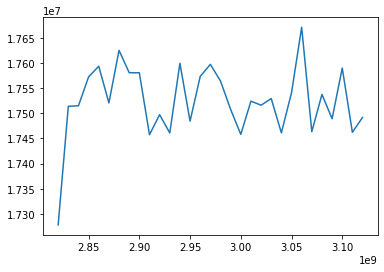

In [120]:
#base settings
freq_low = 2820e6
freq_high = 3130e6
freq_step = 10e6
N = 50
clock_rate = 200 #Hz
trigger_input = None
pulser = None
use_new_edge_task = False
new_clock_task = False

#changed settings
use_new_edge_task = True
new_clock_task = True
trigger_input = 'PFI0'
pulser = p

new_edge_and_new_clock_style_w_triggers = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, trigger_input, pulser, use_new_edge_task, new_clock_task)
plt.plot(new_edge_and_new_clock_style_w_triggers.keys(), new_edge_and_new_clock_style_w_triggers.values())

In [139]:
#base settings
freq_low = 2820e6
freq_high = 3130e6
freq_step = 10e6
N = 50
clock_rate = 200 #Hz
trigger_input = None
pulser = None
use_new_edge_task = False
new_clock_task = False


qudi_style_with_edge_det =  run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, trigger_input, pulser, use_new_edge_task, new_clock_task)


acquiring 0.25 seconds of data per sample
here
2.82 GHz: 174861.0 counts
2.82 GHz: 699444.0 counts/second
2.92 GHz: 176011.0 counts
2.92 GHz: 704044.0 counts/second
3.02 GHz: 174996.0 counts
3.02 GHz: 699984.0 counts/second
3.12 GHz: 175488.0 counts
3.12 GHz: 701952.0 counts/second


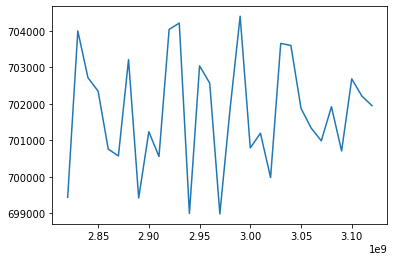

In [140]:
plt.plot(qudi_style_with_edge_det.keys(), qudi_style_with_edge_det.values())


In [150]:
rfsynth.rf_on(0)
rfsynth.rf_off(1)

In [148]:
rfsynth.set_channel_fixed_output(0, -5.0, freq_low)

In [151]:
rfsynth.current_status()

['C) Control Channel (A(0) or B(1))  1',
 'f) RF Frequency Now (MHz) 2820.00000000, 1000.00000000',
 'W) RF Power (dBm) -5.000, 0.000',
 'V) Amp Calibration success? 1',
 'Z) Temperature Comp (0=none, 1=on set, 2=1sec, 3=10sec) 3, 3',
 'a) VGA DAC Setting (0=min, 4000=max) 777, 993',
 '~) RF Phase Step (0=minimum, 360.0=maximum) 0.0000, 0.0000',
 'h) RF High(1) or Low(0) Power 1, 0',
 'E) PLL Chip En On(1) or Off(0) 1, 0',
 'U) PLL charge pump current 5, 5',
 'b) REF Doubler On(1) or Off(0) 0, 0',
 'i) Channel spacing (Hz) 100.000, 100.000',
 'x) Reference (external=0, int 27MHz=1, int 10MHz=2) 1',
 '*) PLL reference frequency (MHz) 27.00000000',
 'l) Sweep lower frequency (MHz) 1000.00000000, 1000.00000000',
 'u) Sweep upper frequency (MHz) 5000.00000000, 5000.00000000',
 's) Sweep step size (MHz/%) 200.00000000, 200.00000000',
 't) Sweep step time (mS) 1.000, 1.000',
 '[) Sweep amplitude low (dBm) 0.000, 0.000',
 ']) Sweep amplitude high (dBm) 0.000, 0.000',
 '^) Sweep direction (up=

In [158]:
#qudi style, ODMR
freq_low = 2820e6
freq_high = 2920e6
freq_step = 1e6
N = 50
clock_rate = 100 #Hz
trigger_input = None
pulser = None
use_new_edge_task = True
new_clock_task = True

data = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, trigger_input, pulser, use_new_edge_task, new_clock_task)

acquiring 0.5 seconds of data per sample
2.82 GHz: 1870424.0 counts
2.82 GHz: 3740848.0 counts/second
2.83 GHz: 1861647.0 counts
2.83 GHz: 3723294.0 counts/second
2.84 GHz: 1850846.0 counts
2.84 GHz: 3701692.0 counts/second
2.85 GHz: 1836909.0 counts
2.85 GHz: 3673818.0 counts/second
2.86 GHz: 1779597.0 counts
2.86 GHz: 3559194.0 counts/second
2.87 GHz: 1730812.0 counts
2.87 GHz: 3461624.0 counts/second
2.88 GHz: 1853038.0 counts
2.88 GHz: 3706076.0 counts/second
2.89 GHz: 2009869.0 counts
2.89 GHz: 4019738.0 counts/second
2.9 GHz: 2142724.0 counts
2.9 GHz: 4285448.0 counts/second
2.91 GHz: 2282237.0 counts
2.91 GHz: 4564474.0 counts/second


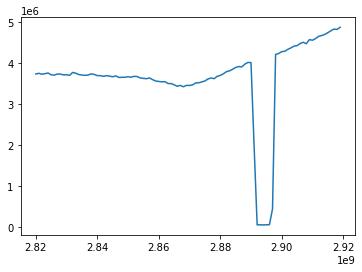

In [159]:
plt.plot(data.keys(), data.values())

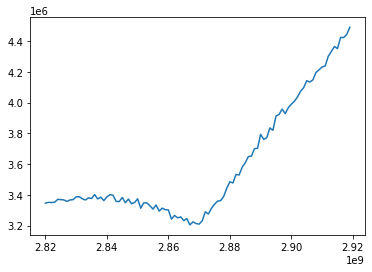

In [157]:
plt.plot(data.keys(), data.values())

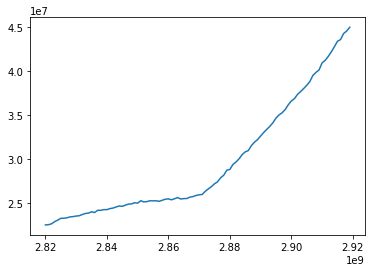

In [155]:
plt.plot(data.keys(), data.values())

In [160]:
#qudi style, ODMR
freq_low = 2820e6
freq_high = 2920e6
freq_step = 1e6
N = 50
clock_rate = 100 #Hz
trigger_input = None
pulser = None
use_new_edge_task = False
new_clock_task = False

data = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, trigger_input, pulser, use_new_edge_task, new_clock_task)

acquiring 0.5 seconds of data per sample
here
2.82 GHz: 64951.0 counts
2.82 GHz: 129902.0 counts/second
2.83 GHz: 66270.0 counts
2.83 GHz: 132540.0 counts/second
2.84 GHz: 67727.0 counts
2.84 GHz: 135454.0 counts/second
2.85 GHz: 67706.0 counts
2.85 GHz: 135412.0 counts/second
2.86 GHz: 67371.0 counts
2.86 GHz: 134742.0 counts/second
2.87 GHz: 67448.0 counts
2.87 GHz: 134896.0 counts/second
2.88 GHz: 73347.0 counts
2.88 GHz: 146694.0 counts/second
2.89 GHz: 81129.0 counts
2.89 GHz: 162258.0 counts/second
2.9 GHz: 88750.0 counts
2.9 GHz: 177500.0 counts/second
2.91 GHz: 95408.0 counts
2.91 GHz: 190816.0 counts/second


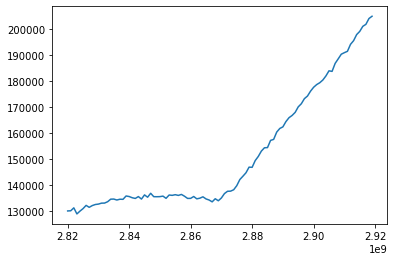

In [161]:
plt.plot(data.keys(), data.values())

In [165]:
#qudi style, ODMR
freq_low = 2220e6
freq_high = 3220e6
freq_step = 5e6
N = 50
clock_rate = 100 #Hz
trigger_input = None
pulser = None
use_new_edge_task = True
new_clock_task = True

data = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, trigger_input, pulser, use_new_edge_task, new_clock_task)

acquiring 0.5 seconds of data per sample
2.22 GHz: 1752412.0 counts
2.22 GHz: 3504824.0 counts/second
2.27 GHz: 1772898.0 counts
2.27 GHz: 3545796.0 counts/second
2.32 GHz: 1760482.0 counts
2.32 GHz: 3520964.0 counts/second
2.37 GHz: 1765607.0 counts
2.37 GHz: 3531214.0 counts/second
2.42 GHz: 1737149.0 counts
2.42 GHz: 3474298.0 counts/second
2.47 GHz: 1724083.0 counts
2.47 GHz: 3448166.0 counts/second
2.52 GHz: 1714183.0 counts
2.52 GHz: 3428366.0 counts/second
2.57 GHz: 1720118.0 counts
2.57 GHz: 3440236.0 counts/second
2.62 GHz: 1714778.0 counts
2.62 GHz: 3429556.0 counts/second
2.67 GHz: 1734723.0 counts
2.67 GHz: 3469446.0 counts/second
2.72 GHz: 1732444.0 counts
2.72 GHz: 3464888.0 counts/second
2.77 GHz: 1734948.0 counts
2.77 GHz: 3469896.0 counts/second
2.82 GHz: 1739982.0 counts
2.82 GHz: 3479964.0 counts/second
2.87 GHz: 1611835.0 counts
2.87 GHz: 3223670.0 counts/second
2.92 GHz: 2009763.0 counts
2.92 GHz: 4019526.0 counts/second
2.97 GHz: 2130350.0 counts
2.97 GHz: 4260700

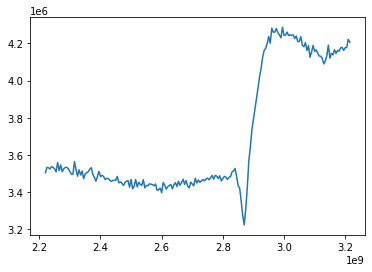

In [166]:
plt.plot(data.keys(), data.values())

In [167]:
#qudi style, ODMR
freq_low = 2800e6
freq_high = 2920e6
freq_step = 0.5e6
N = 50
clock_rate = 100 #Hz
trigger_input = None
pulser = None
use_new_edge_task = True
new_clock_task = True

data = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, trigger_input, pulser, use_new_edge_task, new_clock_task)

acquiring 0.5 seconds of data per sample
2.8 GHz: 1783946.0 counts
2.8 GHz: 3567892.0 counts/second
2.805 GHz: 1821912.0 counts
2.805 GHz: 3643824.0 counts/second
2.81 GHz: 1840256.0 counts
2.81 GHz: 3680512.0 counts/second
2.815 GHz: 1872755.0 counts
2.815 GHz: 3745510.0 counts/second
2.82 GHz: 1884699.0 counts
2.82 GHz: 3769398.0 counts/second
2.825 GHz: 1924629.0 counts
2.825 GHz: 3849258.0 counts/second
2.83 GHz: 1971155.0 counts
2.83 GHz: 3942310.0 counts/second
2.835 GHz: 2019611.0 counts
2.835 GHz: 4039222.0 counts/second
2.84 GHz: 2054861.0 counts
2.84 GHz: 4109722.0 counts/second
2.845 GHz: 2081627.0 counts
2.845 GHz: 4163254.0 counts/second
2.85 GHz: 2114953.0 counts
2.85 GHz: 4229906.0 counts/second
2.855 GHz: 2137556.0 counts
2.855 GHz: 4275112.0 counts/second
2.86 GHz: 2171745.0 counts
2.86 GHz: 4343490.0 counts/second
2.865 GHz: 2173636.0 counts
2.865 GHz: 4347272.0 counts/second
2.87 GHz: 2229646.0 counts
2.87 GHz: 4459292.0 counts/second
2.875 GHz: 2379376.0 counts
2.87

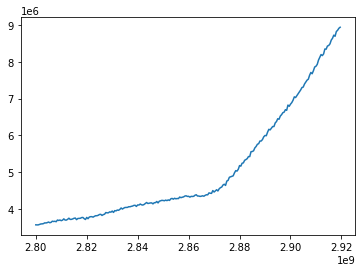

In [168]:
plt.plot(data.keys(), data.values())

In [169]:
#qudi style, ODMR
freq_low = 2220e6
freq_high = 3220e6
freq_step = 5e6
N = 50
clock_rate = 100 #Hz
trigger_input = None
pulser = None
use_new_edge_task = True
new_clock_task = True

data = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, trigger_input, pulser, use_new_edge_task, new_clock_task)

acquiring 0.5 seconds of data per sample
2.22 GHz: 2690855.0 counts
2.22 GHz: 5381710.0 counts/second
2.27 GHz: 2654089.0 counts
2.27 GHz: 5308178.0 counts/second
2.32 GHz: 2599959.0 counts
2.32 GHz: 5199918.0 counts/second
2.37 GHz: 2538613.0 counts
2.37 GHz: 5077226.0 counts/second
2.42 GHz: 2517788.0 counts
2.42 GHz: 5035576.0 counts/second
2.47 GHz: 2467591.0 counts
2.47 GHz: 4935182.0 counts/second
2.52 GHz: 2452388.0 counts
2.52 GHz: 4904776.0 counts/second
2.57 GHz: 2407232.0 counts
2.57 GHz: 4814464.0 counts/second
2.62 GHz: 2392397.0 counts
2.62 GHz: 4784794.0 counts/second
2.67 GHz: 2384785.0 counts
2.67 GHz: 4769570.0 counts/second
2.72 GHz: 2357949.0 counts
2.72 GHz: 4715898.0 counts/second
2.77 GHz: 2371523.0 counts
2.77 GHz: 4743046.0 counts/second
2.82 GHz: 2375434.0 counts
2.82 GHz: 4750868.0 counts/second
2.87 GHz: 2161322.0 counts
2.87 GHz: 4322644.0 counts/second
2.92 GHz: 2736922.0 counts
2.92 GHz: 5473844.0 counts/second
2.97 GHz: 2943960.0 counts
2.97 GHz: 5887920

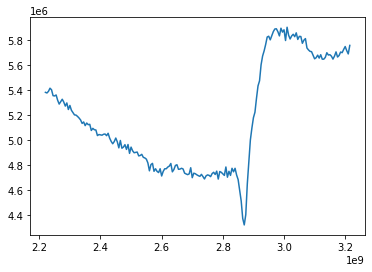

In [170]:
plt.plot(data.keys(), data.values())

In [171]:
#qudi style, ODMR
freq_low = 2220e6
freq_high = 3220e6
freq_step = 5e6
N = 50
clock_rate = 100 #Hz
trigger_input = None
pulser = None
use_new_edge_task = False
new_clock_task = False

data = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, trigger_input, pulser, use_new_edge_task, new_clock_task)

acquiring 0.5 seconds of data per sample
here
2.22 GHz: 93864.0 counts
2.22 GHz: 187728.0 counts/second
2.27 GHz: 95179.0 counts
2.27 GHz: 190358.0 counts/second
2.32 GHz: 94079.0 counts
2.32 GHz: 188158.0 counts/second
2.37 GHz: 94286.0 counts
2.37 GHz: 188572.0 counts/second
2.42 GHz: 94267.0 counts
2.42 GHz: 188534.0 counts/second
2.47 GHz: 93979.0 counts
2.47 GHz: 187958.0 counts/second
2.52 GHz: 94989.0 counts
2.52 GHz: 189978.0 counts/second
2.57 GHz: 94565.0 counts
2.57 GHz: 189130.0 counts/second
2.62 GHz: 93980.0 counts
2.62 GHz: 187960.0 counts/second
2.67 GHz: 94742.0 counts
2.67 GHz: 189484.0 counts/second
2.72 GHz: 96092.0 counts
2.72 GHz: 192184.0 counts/second
2.77 GHz: 96932.0 counts
2.77 GHz: 193864.0 counts/second
2.82 GHz: 95996.0 counts
2.82 GHz: 191992.0 counts/second
2.87 GHz: 88706.0 counts
2.87 GHz: 177412.0 counts/second
2.92 GHz: 112949.0 counts
2.92 GHz: 225898.0 counts/second
2.97 GHz: 121291.0 counts
2.97 GHz: 242582.0 counts/second
3.02 GHz: 120038.0 count

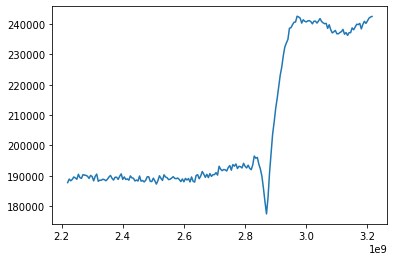

In [172]:
plt.plot(data.keys(), data.values())

In [18]:
#qudi style, ODMR
freq_low = 2220e6
freq_high = 3220e6
freq_step = 5e6
N = 50
clock_rate = 100 #Hz
trigger_input = None
pulser = None
use_new_edge_task = False
new_clock_task = False

data = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, trigger_input, pulser, use_new_edge_task, new_clock_task)

acquiring 0.5 seconds of data per sample
here
2.22 GHz: 2919.3 mean counts
2.22 GHz: 291930.0 mean counts/second
2.27 GHz: 2940.86 mean counts
2.27 GHz: 294086.0 mean counts/second
2.32 GHz: 2932.44 mean counts
2.32 GHz: 293244.0 mean counts/second
2.37 GHz: 2905.06 mean counts
2.37 GHz: 290506.0 mean counts/second
2.42 GHz: 2912.8 mean counts
2.42 GHz: 291280.0 mean counts/second
2.47 GHz: 2916.94 mean counts
2.47 GHz: 291694.0 mean counts/second
2.52 GHz: 2898.18 mean counts
2.52 GHz: 289818.0 mean counts/second
2.57 GHz: 2892.66 mean counts
2.57 GHz: 289266.0 mean counts/second
2.62 GHz: 2927.6 mean counts
2.62 GHz: 292760.0 mean counts/second
2.67 GHz: 2966.88 mean counts
2.67 GHz: 296688.0 mean counts/second
2.72 GHz: 2923.36 mean counts
2.72 GHz: 292336.0 mean counts/second
2.77 GHz: 2936.8 mean counts
2.77 GHz: 293680.0 mean counts/second
2.82 GHz: 2915.78 mean counts
2.82 GHz: 291578.0 mean counts/second
2.87 GHz: 2892.26 mean counts
2.87 GHz: 289226.0 mean counts/second
2.92 G

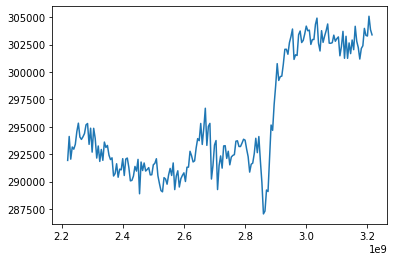

In [19]:
plt.plot(data.keys(), data.values())

In [20]:
#qudi style, ODMR
freq_low = 2220e6
freq_high = 3220e6
freq_step = 5e6
N = 50
clock_rate = 100 #Hz
trigger_input = None
pulser = None
use_new_edge_task = True
new_clock_task = True

data = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, trigger_input, pulser, use_new_edge_task, new_clock_task)

acquiring 0.5 seconds of data per sample
2.22 GHz: 76150.74 mean counts
2.22 GHz: 7615074.000000001 mean counts/second
2.27 GHz: 76501.32 mean counts
2.27 GHz: 7650132.000000001 mean counts/second
2.32 GHz: 75912.3 mean counts
2.32 GHz: 7591230.0 mean counts/second
2.37 GHz: 75872.38 mean counts
2.37 GHz: 7587238.0 mean counts/second
2.42 GHz: 75555.0 mean counts
2.42 GHz: 7555500.0 mean counts/second
2.47 GHz: 74954.68 mean counts
2.47 GHz: 7495467.999999999 mean counts/second
2.52 GHz: 75480.64 mean counts
2.52 GHz: 7548064.0 mean counts/second
2.57 GHz: 75024.94 mean counts
2.57 GHz: 7502494.0 mean counts/second
2.62 GHz: 75408.06 mean counts
2.62 GHz: 7540806.0 mean counts/second
2.67 GHz: 75129.82 mean counts
2.67 GHz: 7512982.000000001 mean counts/second
2.72 GHz: 74863.58 mean counts
2.72 GHz: 7486358.0 mean counts/second
2.77 GHz: 74869.4 mean counts
2.77 GHz: 7486939.999999999 mean counts/second
2.82 GHz: 74932.32 mean counts
2.82 GHz: 7493232.000000001 mean counts/second
2.87

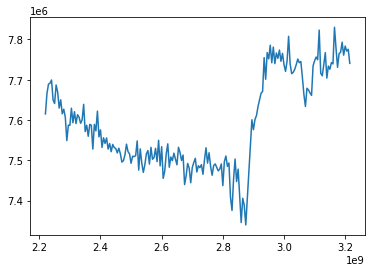

In [21]:
plt.plot(data.keys(), data.values())

In [22]:
#qudi style, ODMR
freq_low = 2800e6
freq_high = 2920e6
freq_step = 1e6
N = 200
clock_rate = 200 #Hz
trigger_input = None
pulser = None
use_new_edge_task = True
new_clock_task = True

data = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, trigger_input, pulser, use_new_edge_task, new_clock_task)

acquiring 1.0 seconds of data per sample
2.8 GHz: 145116.47 mean counts
2.8 GHz: 29023294.0 mean counts/second
2.81 GHz: 146293.47 mean counts
2.81 GHz: 29258694.0 mean counts/second
2.82 GHz: 147617.93 mean counts
2.82 GHz: 29523586.0 mean counts/second
2.83 GHz: 148452.415 mean counts
2.83 GHz: 29690483.0 mean counts/second
2.84 GHz: 148859.75 mean counts
2.84 GHz: 29771950.0 mean counts/second
2.85 GHz: 148905.69 mean counts
2.85 GHz: 29781138.0 mean counts/second
2.86 GHz: 149099.705 mean counts
2.86 GHz: 29819940.999999996 mean counts/second
2.87 GHz: 150429.435 mean counts
2.87 GHz: 30085887.0 mean counts/second
2.88 GHz: 154965.075 mean counts
2.88 GHz: 30993015.000000004 mean counts/second
2.89 GHz: 159000.56 mean counts
2.89 GHz: 31800112.0 mean counts/second
2.9 GHz: 163328.59 mean counts
2.9 GHz: 32665718.0 mean counts/second
2.91 GHz: 166750.335 mean counts
2.91 GHz: 33350067.0 mean counts/second


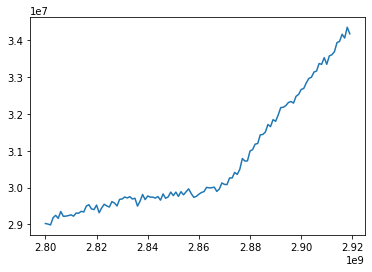

In [23]:
plt.plot(data.keys(), data.values())

In [24]:
#qudi style, ODMR
freq_low = 2800e6
freq_high = 2920e6
freq_step = 1e6
N = 200
clock_rate = 200 #Hz
trigger_input = None
pulser = None
use_new_edge_task = False
new_clock_task = False

data = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, trigger_input, pulser, use_new_edge_task, new_clock_task)

acquiring 1.0 seconds of data per sample
here
2.8 GHz: 1644.89 mean counts
2.8 GHz: 328978.0 mean counts/second
2.81 GHz: 1622.545 mean counts
2.81 GHz: 324509.0 mean counts/second
2.82 GHz: 1600.36 mean counts
2.82 GHz: 320072.0 mean counts/second
2.83 GHz: 1593.365 mean counts
2.83 GHz: 318673.0 mean counts/second
2.84 GHz: 1597.39 mean counts
2.84 GHz: 319478.0 mean counts/second
2.85 GHz: 1593.76 mean counts
2.85 GHz: 318752.0 mean counts/second
2.86 GHz: 1586.57 mean counts
2.86 GHz: 317314.0 mean counts/second
2.87 GHz: 1584.735 mean counts
2.87 GHz: 316947.0 mean counts/second
2.88 GHz: 1623.595 mean counts
2.88 GHz: 324719.0 mean counts/second
2.89 GHz: 1680.235 mean counts
2.89 GHz: 336047.0 mean counts/second
2.9 GHz: 1721.31 mean counts
2.9 GHz: 344262.0 mean counts/second
2.91 GHz: 1762.96 mean counts
2.91 GHz: 352592.0 mean counts/second


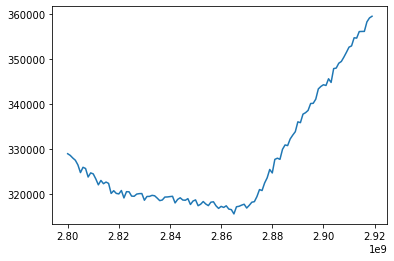

In [25]:
plt.plot(data.keys(), data.values())